In [29]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [2]:
matplotlib.rcParams['figure.figsize'] = [10, 20]

### Read in Data

In [3]:
df = pd.read_csv("/Users/gabrieltaylor/Python/STAT542/en.openfoodfacts.org.products.tsv", sep = "\t")

/Users/gabrieltaylor/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot Missing Values

In [5]:
miss_vals = pd.DataFrame(df.isna().mean()).reset_index()
miss_vals.columns = ["Columns", "MV Rate"]
miss_vals = miss_vals.sort_values("MV Rate")

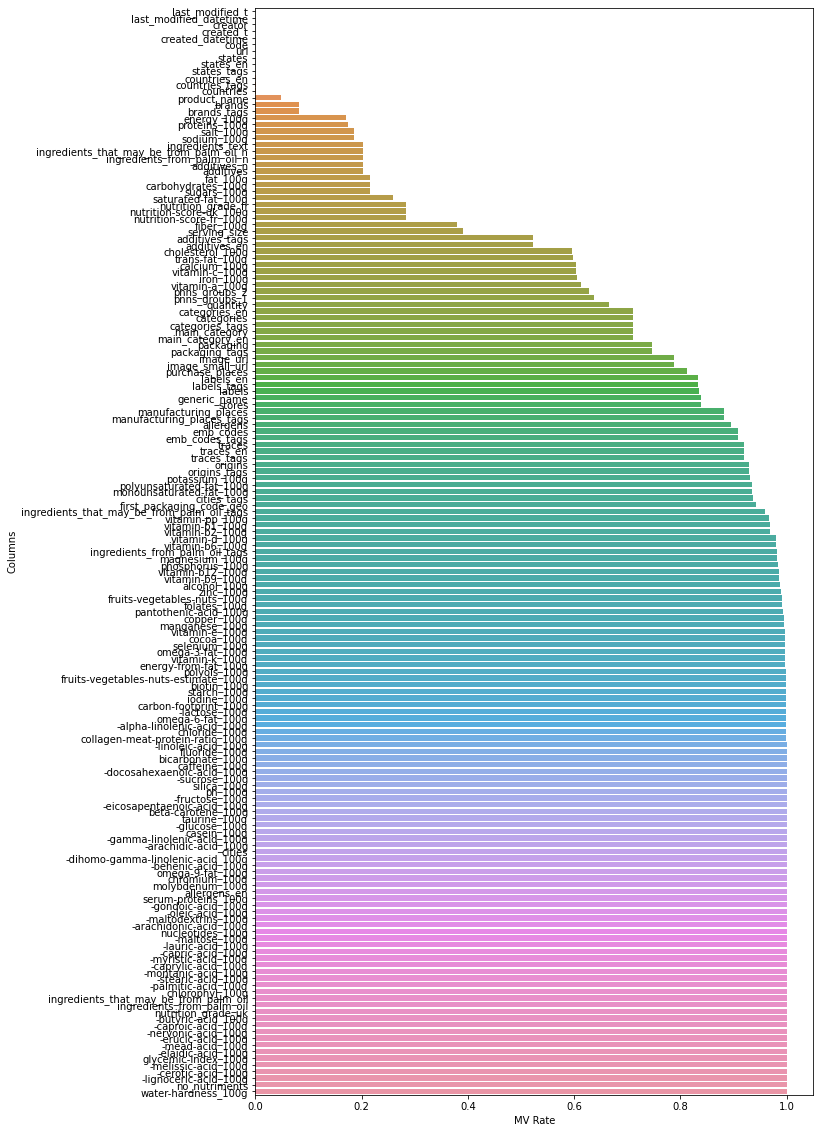

In [6]:
sns.barplot("MV Rate", "Columns", data = miss_vals, orient = "h")

### Remove Columns above 30% Missing Values

In [7]:
keep_cols = miss_vals[miss_vals["MV Rate"] < 0.3]["Columns"]

In [8]:
df2 = df[keep_cols]

### Remove General Information 

In [66]:
rm_cols = [ 'last_modified_t',
            'last_modified_datetime',
             'creator',
             'created_t',
             'created_datetime',
             'code',
             'url',
             'states',
             'states_en',
             'states_tags',
             'countries_en',
             'countries_tags',
             'countries',
             'ingredients_that_may_be_from_palm_oil_n',
             'ingredients_from_palm_oil_n',
             'product_name', ### Perhaps Keep
             'brands', ### Perhaps Keep
             'brands_tags',
             'additives', ### contained in ingredients
             'additives_n',
             'nutrition-score-uk_100g', ### Related to target
             'nutrition_grade_fr', ### Related to target
             'salt_100g' ### Sodium will suffice
          ]

In [67]:
df3 = df2.drop(rm_cols, axis = 1)

## Check Missingness

In [68]:
pd.DataFrame(df3.isna().mean()).reset_index()

,index,0
0,energy_100g,0.170380
1,proteins_100g,0.173768
2,sodium_100g,0.186315
3,ingredients_text,0.202608
4,fat_100g,0.214956
5,carbohydrates_100g,0.215734
6,sugars_100g,0.215829
7,saturated-fat_100g,0.258980
8,nutrition-score-fr_100g,0.284167


### Remove All Missing Rows For Right Now

In [80]:
df4 = df3.dropna()

In [85]:
df4.shape[0] / df3.shape[0]

0.6427714751971059

## Document Term Matrix For Ingredients

Keep only latin letters

In [86]:
ingredients = ["Missing" if pd.isna(ing) else re.sub('[^A-Za-z]', ' ', ing) for ing in df4['ingredients_text']]

List of all words

In [87]:
all_words = [i for ing in ingredients for i in ing.split()]

List of stop words (will be improved later)

In [88]:
rm_words = ['de', 'contains', 's', 'et', 'of', 'en', 'less', 'p']

Keep only the most common words

In [89]:
most_common_words = Counter(all_words).most_common(1000)
most_common_words = [word[0] for word in most_common_words if word[0] not in rm_words]

In [90]:
keep_ingredients = [" ".join([word for word in ing.split() if word in most_common_words]) for ing in ingredients ]

Form the document term matrix

In [91]:
vec = CountVectorizer()
X = vec.fit_transform(keep_ingredients)
dtm = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
dtm.to_csv("/Users/gabrieltaylor/Python/STAT542/dtm.csv")
dtm.head()

,abri,abricot,ac,acacia,aceite,acesulfame,acetate,acetic,acid,acide,...,with,xanthan,xanthane,yeast,yellow,yogurt,yolk,yolks,zinc,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
df5 = pd.concat([df4.reset_index(drop = True), dtm], axis = 1)

### Drop Ingredients Column

In [106]:
df6 = df5.drop('ingredients_text', axis = 1)

# Summary Stats

In [107]:
df6.iloc[ : , :8].describe()

,energy_100g,proteins_100g,sodium_100g,fat_100g,carbohydrates_100g,sugars_100g,saturated-fat_100g,nutrition-score-fr_100g
count,228844.000000,228844.000000,228844.000000,228844.000000,228844.000000,228844.000000,228844.000000,228844.000000
mean,1171.911669,7.785690,0.640654,13.320101,32.532443,14.799959,4.880342,9.166349
std,765.979279,8.191132,53.200182,16.262705,28.312893,19.721838,7.408247,8.998946
min,0.000000,-3.570000,0.000000,0.000000,0.000000,-17.860000,0.000000,-15.000000
25%,448.000000,1.770000,0.039370,0.830000,6.670000,1.200000,0.000000,1.000000
50%,1176.000000,5.620000,0.250000,7.100000,22.670000,5.000000,1.790000,10.000000
75%,1707.000000,10.800000,0.536000,21.430000,58.180000,22.580000,7.060000,16.000000
max,14644.000000,305.000000,25320.000000,100.000000,165.000000,145.000000,100.000000,40.000000
